In [83]:
import os
import pybullet_envs
import numpy as np
import matplotlib.pyplot as plt
# import panda_gym # Not in requirements, required for panda envs, get latest from here: https://github.com/qgallouedec/panda-gym, don't use version from pypy as we needed a bugfix from the source 

from seagul.zoo3_utils import load_zoo_agent, ALGOS, do_rollout_stable
from seagul.mesh import dict_to_array
import pandas as pd

path_to_zoo = "/home/sgillen/work/external/rl-baselines3-zoo/" # Very hacky but this is what we do for now. use: git clone --recursive https://github.com/DLR-RM/rl-baselines3-zoo

model_dir = os.path.abspath('')  + "/keep_agents/panda_adim1"
csv_file = os.path.abspath('')  + "/keep_csv/panda_adim1.csv"

df = pd.read_csv(csv_file)[['post', 'config.algo', 'config.env_name', 'ureward_mean', 'ureward_std', 'mdim_mean', 'cdim_mean', 'cdim_std', 'mdim_nan_mean', 'mdim_std', 'nreward_mean', 'nreward_std', 'len_mean',
                             'cdim_nan_mean']]#, 'config.post']]

df = df.loc[df['config.env_name'] != 'PandaStack-v1'] # Baseline can't even solve this so we just ingore panda stack

# Mdim and Cdim are the lower and upper bounds on our dimensionality respectively, we trained with the average but recorded both bounds, we then average the two bounds for the final table as well. 
df['avgdim_mean'] = df[['mdim_mean', 'cdim_mean']].mean(axis=1)
df['avgdim_std'] = df[['mdim_std', 'cdim_std']].mean(axis=1)

In [84]:
# Just manipulating the data into something more readable

df2 = pd.DataFrame()

post_dict = {}
for post in df['post']:
    post_dict[post] = 1 
    
# for post in post_dict.keys():
#     display(df[df['post'] == post])
    
#for post in post_dict.keys():
post_name = 'DualRewardProd_adim_safe_stable_nolen'
env_disp_name = "Environment"
algo_disp_name = "Algorithm"

#df2 = df[(df['post'] == 'iden') | (df['post'] == 'DualRewardDiv_cdim_safe_stable_nolen')]
#df2.set_index(['config.env_name', 'config.algo'])


df2[env_disp_name] = df[df['post'] == 'iden']['config.env_name']
df2[algo_disp_name] = df[df['post'] == 'iden']['config.algo']
df2['bdim_mean'] = df[df['post'] == 'iden']['avgdim_mean']
df2['bdim_std'] = df[df['post'] == 'iden']['avgdim_std']
df2['adim_mean'] = df[df['post'] == post_name]['avgdim_mean'].to_numpy()
df2['adim_std'] = df[df['post'] == post_name]['avgdim_std'].to_numpy()

df2['brew_mean'] = df[df['post'] == 'iden']['ureward_mean']
df2['brew_std'] = df[df['post'] == 'iden']['ureward_std']
df2['arew_mean'] = df[df['post'] == post_name]['ureward_mean'].to_numpy()
df2['arew_std'] = df[df['post'] == post_name]['ureward_std'].to_numpy()

df2 = df2.round({'bdim_mean':2,'bdim_std':1,'adim_mean':2, "adim_std":1})
df2['bdim_mean'] = df2['bdim_mean']
df2['bdim_mean'] = df2[['bdim_mean', 'bdim_std']].astype(str).agg(' ± '.join, axis=1) 
df2.drop('bdim_std', axis=1, inplace=True)
df2['adim_mean'] = df2['adim_mean']
df2['adim_mean'] = df2[['adim_mean', 'adim_std']].astype(str).agg(' ± '.join, axis=1) 

df2 = df2.round({'brew_mean':2,'brew_std':1,'arew_mean':2, "arew_std":1})
df2['brew_mean'] = df2['brew_mean'].astype(int)
df2['brew_mean'] = df2[['brew_mean', 'brew_std']].astype(str).agg(' ± '.join, axis=1) 
df2.drop('brew_std', axis=1, inplace=True)
df2['arew_mean'] = df2['arew_mean'].astype(int)
df2['arew_mean'] = df2[['arew_mean', 'arew_std']].astype(str).agg(' ± '.join, axis=1) 

df2.drop('adim_std', axis=1, inplace=True)
df2 = df2.rename({'bdim_mean':'Baseline Dim.'}, axis=1)
df2 = df2.rename({'adim_mean':'Refined  Dim.'}, axis=1)

df2.drop('arew_std', axis=1, inplace=True)
df2 = df2.rename({'brew_mean':'Baseline Return'}, axis=1)
df2 = df2.rename({'arew_mean':'Refined  Return'}, axis=1)

df2.set_index(["Environment", "Algorithm"]).sort_index()

env_dict = {}
for env in df2['Environment']:
    env_dict[env] = 1 

df2.drop("Algorithm", axis=1, inplace=True)
print(df2.to_latex(index=False))
# for post in ['iden', 'DualRewardDiv_cdim_safe_stable_nolen']:
#     dfp = df[df['post'] == post]
#     print(post)
#     dfd = dfp.drop('post', axis=1, inplace=False)
#     display(dfd)

\begin{tabular}{lllll}
\toprule
          Environment & Baseline Dim. & Refined  Dim. & Baseline Return & Refined  Return \\
\midrule
        PandaReach-v1 &    2.73 ± 0.7 &    2.28 ± 0.5 &        -2 ± 0.6 &        -1 ± 0.7 \\
 PandaPickAndPlace-v1 &    1.63 ± 0.3 &    1.61 ± 0.5 &        -6 ± 2.6 &      -11 ± 13.3 \\
         PandaPush-v1 &    1.91 ± 0.5 &    1.68 ± 0.3 &        -6 ± 2.7 &        -7 ± 3.0 \\
        PandaSlide-v1 &    1.89 ± 0.4 &    1.53 ± 0.3 &       -22 ± 7.1 &      -41 ± 12.4 \\
\bottomrule
\end{tabular}



In [86]:
# Iterate through save directory and load the saved models

model_dict = {}
env_dict = {}

for algo_file in os.scandir(model_dir):
    algo_dir = algo_file.path
    algo = algo_dir.split("/")[-1]
    model_dict[algo] = {}
    env_dict[algo] = {}
    for env_file in os.scandir(algo_dir):
        env_dir = env_file.path
        env_name = env_dir.split("/")[-1]
        model_dict[algo][env_name] = {}
        env_dict[algo][env_name] = {}
        env, original_model = load_zoo_agent(env_name, algo, zoo_path = path_to_zoo)
        env_dict[algo][env_name] = env
        model_dict[algo][env_name]['original'] = original_model
        for pkl_file in os.scandir(env_dir):
            post_name = pkl_file.path.split("/")[-1].split(".")[0]
            model_dict[algo][env_name][post_name] = ALGOS[algo].load(pkl_file.path, env=env, device='cpu')

/home/sgillen/work/external/rl-baselines3-zoo//rl-trained-agents/tqc/PandaPickAndPlace-v1_1/PandaPickAndPlace-v1
/home/sgillen/work/external/rl-baselines3-zoo//rl-trained-agents/tqc/PandaReach-v1_1/PandaReach-v1
Loading running average
with params: {'norm_obs': True, 'norm_reward': True}
/home/sgillen/work/external/rl-baselines3-zoo//rl-trained-agents/tqc/PandaPush-v1_1/PandaPush-v1
/home/sgillen/work/external/rl-baselines3-zoo//rl-trained-agents/tqc/PandaStack-v1_1/PandaStack-v1
/home/sgillen/work/external/rl-baselines3-zoo//rl-trained-agents/tqc/PandaSlide-v1_2/PandaSlide-v1


In [88]:
algo_list = list(model_dict.keys())
env_list = list(model_dict[algo_list[0]].keys())
post_list = list(model_dict[algo_list[0]][env_list[0]].keys())

print(algo_list) # Original Algorithm
print(env_list) # Environment

# Postprocessor, autogenerated names. "original" means the original agent from zoo without additional training, "postprocess_default" means just ARS with not extra reward.
# Any other name is some new reward functio 
print(post_list)

['tqc']
['PandaPickAndPlace-v1', 'PandaReach-v1', 'PandaPush-v1', 'PandaStack-v1', 'PandaSlide-v1']
['original', 'postprocess_default', 'DualRewardLin_act_squared', 'DualRewardProd_adim_safe_stable_nolen']


Text(0.5, 0, 'Time (s)')

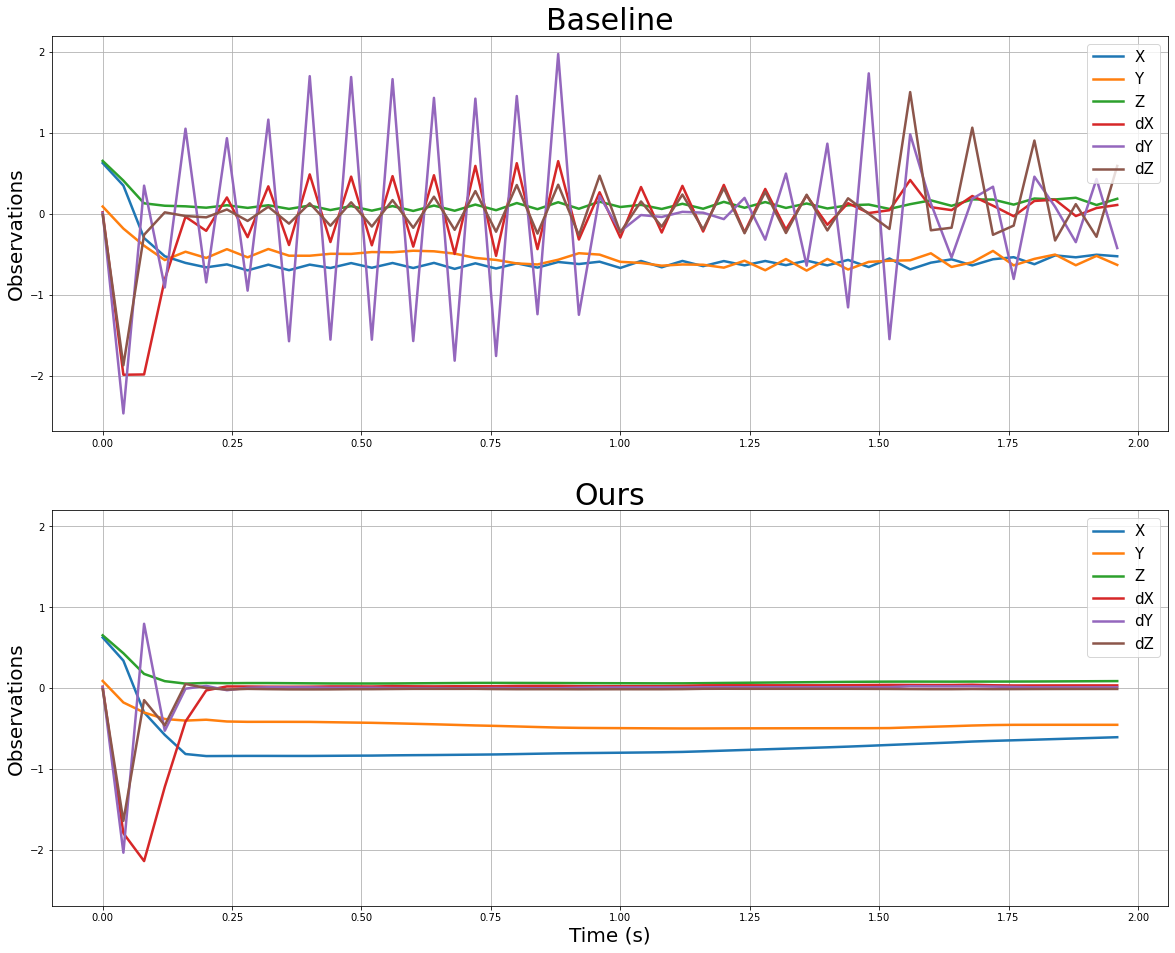

In [100]:

env_name = "PandaReach-v1"
#env_name = "PandaPickAndPlace-v1"
#env_name = "PandaSlide-v1"
#env_name = "PandaReach-v1"

post_inv = ['original', 'DualRewardProd_adim_safe_stable_nolen'] # Which post processors to look at 
#post_inv = post_list
#post_inv = ['original', 'DualRewardProd_adim_safe_stable_nolen', 'DualRewardDiv_adim_safe_stable_nolen']


figs, axs = plt.subplots(len(post_inv),1, figsize = (20,8*len(post_inv)), sharey=True)


#seed = 648024271 # The exact seed for the plot in the paper
seed = np.random.randint(1,2**32-1) # A completley random seed


env = env_dict['tqc'][env_name]
post_name = ["Baseline", "Ours"]

for i, post in enumerate(post_inv):
    model = model_dict['tqc'][env_name][post]
    obs,act,rew,info = do_rollout_stable(env, model, seed=seed)
    obs,ach,des = dict_to_array(obs)
    axs[i].title.set_text(post_name[i])
    axs[i].title.set_fontsize(30)
    
    axs[i].set_ylabel("Observations", fontsize=20)

    axs[i].plot([20*t/500 for t in range(50)], obs[:,:6], linewidth=2.5)
    axs[i].grid()
    axs[i].legend(["X", "Y", "Z", "dX", "dY", "dZ"], fontsize=15, loc='upper right')
    
#     axs[i,1].plot(ach)
#     axs[i,1].plot(des)
#     axs[i,1].grid()
    

    
axs[1].set_xlabel("Time (s)", fontsize=20)
    
    
    #axs[i].legend()
    #axs[i].set_label(post)

#from seagul.mesh import dict_to_array

In [4]:
# Hack for visualizing, can only load one environment / process with rendering. Need to restart NB to change the env

viz_env = "PandaPush-v1"
model_dict = {}
env_dict = {}

for algo_file in os.scandir(model_dir):
    algo_dir = algo_file.path
    algo = algo_dir.split("/")[-1]
    model_dict[algo] = {}
    env_dict[algo] = {}
    for env_file in os.scandir(algo_dir):
        env_dir = env_file.path
        env_name = env_dir.split("/")[-1]
        model_dict[algo][env_name] = {}
        env_dict[algo][env_name] = {}
        if viz_env in env_name:
        
            env, original_model = load_zoo_agent(env_name, algo, zoo_path = path_to_zoo, env_kwargs={"render":True})
            env_dict[algo][env_name] = env
            model_dict[algo][env_name]['original'] = original_model
            for pkl_file in os.scandir(env_dir):
                post_name = pkl_file.path.split("/")[-1].split(".")[0]
                model_dict[algo][env_name][post_name] = ALGOS[algo].load(pkl_file.path, env=env, device='cpu')

/home/sgillen/work/external/rl-baselines3-zoo//rl-trained-agents/tqc/PandaPush-v1_1/PandaPush-v1


In [28]:
#seed = np.random.randint(1,2**32-1)
env = env_dict['tqc'][viz_env]

model = model_dict['tqc'][viz_env][post_list[0]]
o,a,r,infp = do_rollout_stable(env, model, render=True, render_wait=.025, seed=seed)

# model = model_dict['tqc'][viz_env][post_list[1]]
# o,a,r,infp = do_rollout_stable(env, model, render=True, render_wait=.025, seed=seed)

model = model_dict['tqc'][viz_env][post_list[2]]
o,a,r,infp = do_rollout_stable(env, model, render=True, render_wait=.025, seed=seed)